In [316]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter, defaultdict
import igraph as ig
import leidenalg
import random
import pickle

In [3]:
!python --version

Python 3.12.9


In [317]:
sns.__version__

'0.13.2'

In [4]:
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

In [5]:
# Clustered data
# df = pd.read_csv("clustered_users.csv")
df = pd.read_csv("../../data/sm_data.csv")

In [6]:
df.head()

,UserID,Name,Gender,DOB,Interests,City,Occupation,Budget (£),Age,Age Range
0,75722,Kevin Tabor,Male,1962-09-02,"'Nature', 'Parenting and family'",Liverpool,Project Manager,6376,63,56-65
1,80185,Bethany Buckley,Male,1983-07-28,'Business and entrepreneurship',Stockport,Data Analyst,4205,42,36-45
2,19865,Marsha Ayala,Male,1958-12-18,"'Fashion', 'DIY and crafts', 'Outdoor activities'",Bolton,Cleaner,2725,67,66+
3,76700,Sheryl Hower,Male,1964-04-12,'Business and entrepreneurship',Stockport,Quality Assurance Analyst,4556,61,56-65
4,92992,Robin Garrett,Male,1975-11-26,'Travel',Liverpool,Barista,2322,50,46-55


In [25]:
df.shape

(10000, 10)

In [154]:
df_train = df.head(1500) #Using 1500 records for faster cliustering 

In [206]:
_df_ = df_train.copy()

In [212]:
type(_df_['Interests'][0][0])

str

In [208]:
# Clean and parse the Interests column into a list
_df_['Interests'] = _df_['Interests'].apply(lambda x: [i.strip().strip("'") for i in x.split(',')])

In [157]:
_df.shape

(1500, 10)

In [158]:
_df.head(3)

,UserID,Name,Gender,DOB,Interests,City,Occupation,Budget (£),Age,Age Range
0,75722,Kevin Tabor,Male,1962-09-02,"[Nature, Parenting and family]",Liverpool,Project Manager,6376,63,56-65
1,80185,Bethany Buckley,Male,1983-07-28,[Business and entrepreneurship],Stockport,Data Analyst,4205,42,36-45
2,19865,Marsha Ayala,Male,1958-12-18,"[Fashion, DIY and crafts, Outdoor activities]",Bolton,Cleaner,2725,67,66+


In [204]:
_df.head(3)

,user_id,name,gender,dob,interests,city,occupation,budget,age,age_range,Cluster,Cluster_tag
0,75722,Kevin Tabor,Male,1962-09-02,"Nature, Parenting and family",Liverpool,Project Manager,6376,63,56-65,7,Nature & Travel
1,80185,Bethany Buckley,Male,1983-07-28,Business and entrepreneurship,Stockport,Data Analyst,4205,42,36-45,1,Beauty & Business and entrepreneurship
2,19865,Marsha Ayala,Male,1958-12-18,"Fashion, DIY and crafts, Outdoor activities",Bolton,Cleaner,2725,67,66+,3,Fashion & Gaming


### Start Process!!

### Dataframe in use -> _df 

In [159]:
# --- 2. Create bipartite graph (Users <-> Interests) ---
B = nx.Graph()

# Add users and interests as nodes
for _, row in _df.iterrows():
    user_id = row['UserID']
    B.add_node(user_id, bipartite=0)  # User nodes
    for interest in row['Interests']:
        B.add_node(interest, bipartite=1)  # Interest nodes
        B.add_edge(user_id, interest)

# Separate user nodes
# user_nodes = [n for n, d in B.nodes(data=True) if d['bipartite'] == 0]
user_nodes = sorted([n for n, d in B.nodes(data=True) if d['bipartite'] == 0])

In [160]:
len(user_nodes)

1500

In [161]:
B

In [162]:
# --- 3. Project bipartite to user-user graph based on shared interests ---
user_graph = nx.bipartite.weighted_projected_graph(B, user_nodes)

In [163]:
user_graph

In [164]:
# --- 4. Start Leiden ---

# Convert NetworkX graph to iGraph
edges = [(u, v, d['weight']) for u, v, d in user_graph.edges(data=True)]
G_ig = ig.Graph.TupleList(edges, weights=True, directed=False)

In [190]:
# ####### --- Run Leiden multiple times with different seeds and select best modularity ---#######
# best_modularity = -1.0
# best_partition = None
# best_seed = None

# seeds = range(1, 101, 1)  # Seeds: 10, 20, ..., 100

# for seed in seeds:
#     partition = leidenalg.find_partition(G_ig, leidenalg.RBConfigurationVertexPartition, ‹=1.0, seed=seed) # Try 0.8 to 1.5
#     modularity = partition.modularity

#     print(f"Seed {seed}: modularity = {modularity:.4f}")

#     if modularity > best_modularity:
#         best_modularity = modularity
#         best_partition = partition
#         best_seed = seed

# print(f"\nBest seed: {best_seed} with modularity: {best_modularity:.4f}")

In [165]:
# --- 4.1 Run Leiden community detection algorithm ---
partition = leidenalg.find_partition(G_ig, leidenalg.ModularityVertexPartition, seed=91) # Set fixed random seed

# Map each node to its cluster ID
leiden_partition = {}
for cluster_id, cluster_nodes in enumerate(partition):
    for node_index in cluster_nodes:
        user_id = G_ig.vs[node_index]['name']  # iGraph preserves original node name
        leiden_partition[user_id] = cluster_id + 1 # Shift ID to start from 1

In [321]:
# leiden_partition

In [166]:
modularity = partition.modularity
modularity

0.191718939154232

In [167]:
# --- 5. Add cluster labels back to the DataFrame ---
_df['Cluster'] = _df['UserID'].map(leiden_partition)

In [168]:
_df['Cluster'].unique()

array([7, 1, 3, 2, 5, 4, 6])

In [169]:
# --- 6. Tag each cluster using top-N most common interests ---

top_n = 2  # Change as needed
cluster_interests = defaultdict(list)

for _, row in _df.iterrows():
    cluster = row["Cluster"]
    interests = row["Interests"]
    if cluster is not None:
        cluster_interests[cluster].extend(interests)

# Get top interests per cluster and create tag
cluster_tags = {
    cluster: " & ".join([i[0] for i in Counter(interests).most_common(top_n)])
    for cluster, interests in cluster_interests.items()
}

# Assign tags to DataFrame
_df["Cluster_tag"] = _df["Cluster"].map(cluster_tags)

In [322]:
cluster_tags

{7: 'Nature & Travel',
 1: 'Beauty & Business and entrepreneurship',
 3: 'Fashion & Gaming',
 2: 'DIY and crafts & Travel',
 5: 'Music & Fitness',
 4: 'Education and learning & Art',
 6: 'Cars and automobiles & Parenting and family'}

In [170]:
_df.head(3)

,UserID,Name,Gender,DOB,Interests,City,Occupation,Budget (£),Age,Age Range,Cluster,Cluster_tag
0,75722,Kevin Tabor,Male,1962-09-02,"[Nature, Parenting and family]",Liverpool,Project Manager,6376,63,56-65,7,Nature & Travel
1,80185,Bethany Buckley,Male,1983-07-28,[Business and entrepreneurship],Stockport,Data Analyst,4205,42,36-45,1,Beauty & Business and entrepreneurship
2,19865,Marsha Ayala,Male,1958-12-18,"[Fashion, DIY and crafts, Outdoor activities]",Bolton,Cleaner,2725,67,66+,3,Fashion & Gaming


In [324]:
_df[_df['Cluster'] == 2].head(3)

,user_id,name,gender,dob,interests,city,occupation,budget,age,age_range,Cluster,Cluster_tag
4,92992,Robin Garrett,Male,1975-11-26,Travel,Liverpool,Barista,2322,50,46-55,2,DIY and crafts & Travel
5,76435,Theresa Dominguez,Male,1988-07-26,DIY and crafts,Liverpool,Construction Worker,2815,37,36-45,2,DIY and crafts & Travel
6,84005,James Gass,Female,1967-10-14,"Music, Photography, DIY and crafts, Art, Travel",Stockport,Construction Worker,2755,58,56-65,2,DIY and crafts & Travel


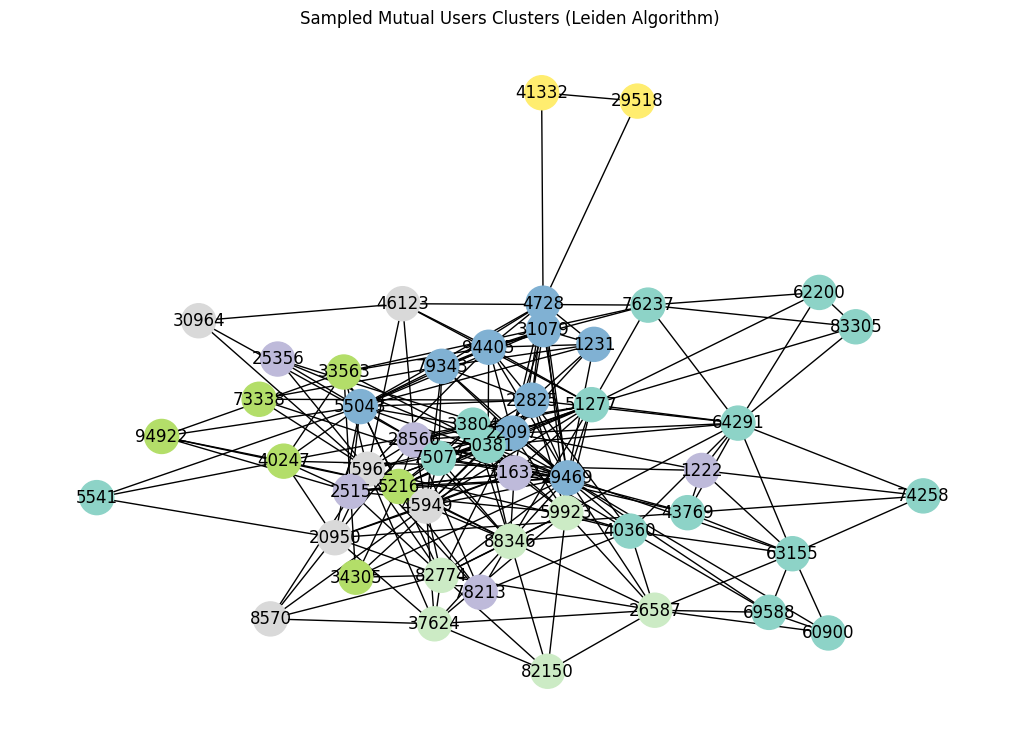

In [325]:
# --- 7. Visualize a sample of the user graph with cluster colors ---

# Sample a subset of users for clearer visualization
sample_size = 50
sampled_users = random.sample(list(user_graph.nodes()), min(sample_size, len(user_graph.nodes())))
sampled_graph = user_graph.subgraph(sampled_users)

# Extract colors for sampled nodes
sampled_colors = [leiden_partition[node] for node in sampled_graph.nodes()]

# Plot
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(sampled_graph, seed=42)
nx.draw(
    sampled_graph, pos,
    node_color=sampled_colors,
    with_labels=True,
    node_size=600,
    cmap=plt.cm.Set3
)
plt.title("Sampled Mutual Users Clusters (Leiden Algorithm)")
plt.show()

In [174]:
_df['Interests'] = _df['Interests'].apply(lambda x: ', '.join(x))

In [175]:
_df.rename(columns={'UserID': 'user_id','Gender': 'gender', 'Name': 'name', 'DOB': 'dob', 'Interests': 'interests', 'City': 'city', 'Occupation': 'occupation', 'Budget (£)': 'budget', 'Age': 'age', 'Age Range': 'age_range'}, inplace=True)

In [176]:
_df.to_csv('clustered_mutuals.csv')

In [178]:
modularity = partition.modularity
print(f"Modularity: {modularity:.4f}")

Modularity: 0.1917


In [179]:
import json
print(json.dumps(cluster_tags, sort_keys=True, indent=4))

{
    "1": "Beauty & Business and entrepreneurship",
    "2": "DIY and crafts & Travel",
    "3": "Fashion & Gaming",
    "4": "Education and learning & Art",
    "5": "Music & Fitness",
    "6": "Cars and automobiles & Parenting and family",
    "7": "Nature & Travel"
}


In [292]:
_df[_df['Cluster'] == 6]

,user_id,name,gender,dob,interests,city,occupation,budget,age,age_range,Cluster,Cluster_tag
36,69770,Franklin Mccrory,Male,1968-03-05,"Cars and automobiles, Parenting and family",Bolton,Business Consultant,8790,57,56-65,6,Cars and automobiles & Parenting and family
54,54375,George Greer,Female,1986-07-13,"Sports, Cars and automobiles, Science, Finance...",Stockport,Loan Officer,5182,39,36-45,6,Cars and automobiles & Parenting and family
63,82200,Josephine Jeanlouis,Female,1970-10-22,"Cars and automobiles, Parenting and family, Bo...",Manchester,Market Research Analyst,6453,55,56-65,6,Cars and automobiles & Parenting and family
80,34081,Edward Coffey,Female,1987-02-23,"Cars and automobiles, Nature, Finance and inve...",Preston,Public Relations Specialist,6732,38,36-45,6,Cars and automobiles & Parenting and family
101,88346,Charles Nelson,Male,1979-10-15,"Cars and automobiles, Business and entrepreneu...",Manchester,Mechanic,4082,46,46-55,6,Cars and automobiles & Parenting and family
...,...,...,...,...,...,...,...,...,...,...,...,...
1452,56632,Donald Payne,Male,1970-01-12,"Photography, Finance and investments, Cars and...",Liverpool,Project Manager,4978,55,56-65,6,Cars and automobiles & Parenting and family
1458,25555,Jimmie Whisler,Female,1998-01-25,"Sports, Finance and investments, Sports, Cars ...",Stockport,Financial Analyst,6534,27,26-35,6,Cars and automobiles & Parenting and family
1467,78602,Todd Kim,Female,1966-05-12,"Cooking, Movies, Cars and automobiles",Stockport,Corporate Trainer,7212,59,56-65,6,Cars and automobiles & Parenting and family
1471,98205,Sara Hunter,Female,1996-06-08,"Photography, Cars and automobiles, Food and di...",Preston,Quality Assurance Analyst,4909,29,26-35,6,Cars and automobiles & Parenting and family


In [182]:
# # Save user graph
# with open("user_graph.pkl", "wb") as f:
#     pickle.dump(user_graph, f)

# Save bipartite graph
with open("bipartite_graph.pkl", "wb") as f:
    pickle.dump(B, f)

# Save Leiden partition (cluster assignments)
with open("leiden_partition.pkl", "wb") as f:
    pickle.dump(leiden_partition, f)

# Save cluster tags
with open("cluster_tags.pkl", "wb") as f:
    pickle.dump(cluster_tags, f)

In [302]:
c = Counter(leiden_partition.values())
print("Cluster sizes:", c)

Cluster sizes: Counter({1: 354, 2: 305, 3: 281, 4: 177, 5: 143, 6: 133, 7: 107})


In [303]:
count_per_group = dict(c)

In [304]:
count_per_group

{1: 354, 2: 305, 3: 281, 4: 177, 5: 143, 6: 133, 7: 107}

In [309]:
count_df = pd.DataFrame.from_dict(count_per_group, orient='index', columns=['count']).reset_index()
count_df.columns = ['group_num', 'count']

In [310]:
count_df

,group_num,count
0,1,354
1,2,305
2,3,281
3,4,177
4,5,143
5,6,133
6,7,107


/var/folders/xt/qdtg9n0d45qbj757bpskpg5m0000gn/T/ipykernel_227/2832577892.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group_num', y='count', data=count_df, palette='viridis')


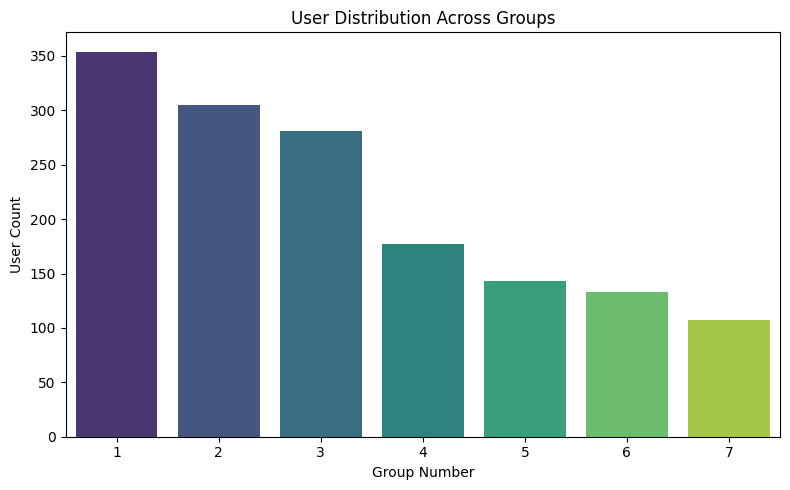

In [318]:
plt.figure(figsize=(8, 5))
sns.barplot(x='group_num', y='count', data=count_df, palette='viridis')
plt.xlabel('Group Number')
plt.ylabel('User Count')
plt.title('User Distribution Across Groups')
plt.tight_layout()
plt.show()

In [ ]:
# Clean and parse the Interests column into a list
# _df['Interests'] = _df['Interests'].apply(lambda x: [i.strip().strip("'") for i in x.split(',')])

In [143]:
# # Create a bipartite graph (users <-> interests)
# B = nx.Graph()

# # Add users and interests as nodes
# for index, row in _df.iterrows():
#     user_id = row['UserID']
#     B.add_node(user_id, bipartite=0)  # Users layer
#     for interest in row['Interests']:
#         B.add_node(interest, bipartite=1)  # Interests layer
#         B.add_edge(user_id, interest)

# # Get user nodes
# # user_nodes = [n for n, d in B.nodes(data=True) if d['bipartite'] == 0]
# user_nodes = sorted([n for n, d in B.nodes(data=True) if d['bipartite'] == 0])

# #Project bipartite graph to user-user graph based on shared interests
# user_graph = nx.bipartite.weighted_projected_graph(B, user_nodes)

In [130]:
# import igraph as ig
# import leidenalg

# # Step 1: Convert NetworkX user_graph to igraph
# nx_to_ig_mapping = {node: idx for idx, node in enumerate(user_graph.nodes())}
# ig_to_nx_mapping = {idx: node for node, idx in nx_to_ig_mapping.items()}

# edges = [(nx_to_ig_mapping[u], nx_to_ig_mapping[v], w['weight']) for u, v, w in user_graph.edges(data=True)]

# g = ig.Graph()
# g.add_vertices(len(user_graph.nodes()))
# g.add_edges([(u, v) for u, v, _ in edges])
# g.es['weight'] = [w for _, _, w in edges]

# # Step 2: Apply Leiden algorithm
# partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition, weights='weight', seed=42) # Set fixed random seed

# # Step 3: Convert partition to user_id -> cluster mapping
# leiden_partition = {}
# for cluster_id, cluster in enumerate(partition):
#     for ig_node_id in cluster:
#         user_id = ig_to_nx_mapping[ig_node_id]
#         leiden_partition[user_id] = cluster_id

# # Step 4: Add cluster labels back to your original DataFrame
# _df['Cluster'] = _df['UserID'].map(leiden_partition)

# # Step 5: Generate cluster tags like before
# from collections import defaultdict, Counter

# top_n = 2
# cluster_interests = defaultdict(list)

# for _, row in _df.iterrows():
#     user_id = row["UserID"]
#     cluster = leiden_partition.get(user_id)
#     interests = row["Interests"]
#     if cluster is not None:
#         cluster_interests[cluster].extend(interests)

# cluster_tags = {}
# for cluster, all_interests in cluster_interests.items():
#     top_interests = [x[0] for x in Counter(all_interests).most_common(top_n)]
#     tag = " & ".join(top_interests)
#     cluster_tags[cluster] = tag

# _df["Cluster_tag"] = _df["Cluster"].map(cluster_tags)
